## Apply FPCA to multi-resolution image dataset

The purpose is to show that FPCA **correctly extracts the main modes** of image variation **regardless of their resolution** (that is, regardless of the number of discrete points on which the function is represented). This confirms that the functional approach makes it possible to work with data with different discretizations (for example, with an uneven grid or different image resolutions).

1. We will download **CIFAR-10** dataset and make it grayscale.
2. We will make sets of pictures with different sizes **(24x24, 32x32 and 64x64)**, using the zoom function for this.
3. We will change each set to the Dense Functional Data format of the FDApy library. The arguments (arg values) will be evenly distributed over the interval [0, 1], and the dimension will correspond to the number of pixels. 
4. Apply FPCA (FDApy.preprocessing.UFPCA) on the pictures. We will have the same number of parts (for example, 10).
5. Visualize the eigenfunctions for each set and compare their shape and smoothness. 
6. Evaluate the quality of reconstruction (F1 with different classifiers) for each set and compare the explained variance (scree plot). 
7. Draw conclusions about what FPCA does to the parts when we change the number of points.

If FPCA works correctly with data of different resolutions, then, despite the differences in the number of points on the grid, the **modes (eigenfunctions) extracted should be interpretable and similar in shape.** There may also be a difference in the mean squared error (MSE) of the reconstruction, which can help to assess how resolution affects the quality of restoration.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray
from skimage.transform import resize
from FDApy.representation.functional_data import DenseFunctionalData, DenseArgvals, DenseValues
from FDApy.preprocessing import UFPCA
from FDApy.visualization import plot

2025-03-17 23:58:08.670392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 23:58:09.317592: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 23:58:09.602843: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 23:58:11.236104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

### Prepare 2 image datasets (CIFAR-10) with different resolutions and convert it to grayscale.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train_gray = np.array([rgb2gray(img) for img in X_train])
X_test_gray = np.array([rgb2gray(img) for img in X_test])
# subset
n_samples = 10000
n_samples_test = int(n_samples*0.3)
X_train_gray = X_train_gray[:n_samples]
y_train = y_train[:n_samples]
X_test_gray = X_test_gray[:n_samples_test]
y_test = y_test[:n_samples_test]
X_test_gray.shape

(3000, 32, 32)

In [4]:
X_test.shape

(10000, 32, 32, 3)

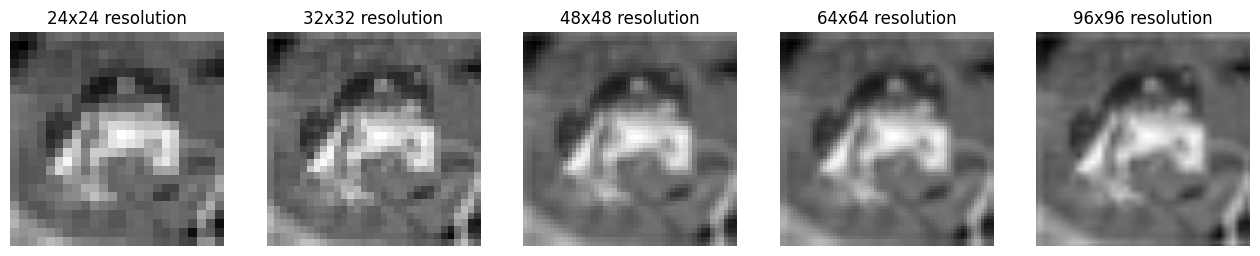

In [5]:
#vectorization
def preprocess_images(images, new_size):
    resized_images = np.array([resize(img, (new_size, new_size), anti_aliasing=True) for img in images])
    flattened = resized_images.reshape(resized_images.shape[0], -1)
    return flattened

res_list = [24, 32, 48, 64, 96]
fig, axes = plt.subplots(1, len(res_list), figsize=(16, 3))
for i,res in enumerate(res_list):
    X = preprocess_images(X_train_gray[:10], res)
    axes[i].imshow(X[0].reshape(res, res), cmap='gray')
    axes[i].set_title(str(res)+'x'+str(res)+ " resolution")
    axes[i].axis("off") 

plt.show()


In [6]:
res_low = 32
res_high = 64

X_train_low  = preprocess_images(X_train_gray, res_low)
X_train_high = preprocess_images(X_train_gray, res_high)
X_test_low  = preprocess_images(X_test_gray, res_low)
X_test_high = preprocess_images(X_test_gray, res_high)

3. Convert each set to the DenseFunctionalData format.


In [18]:
def create_functional_data(X):
    num_points = X.shape[1]
    argvals = DenseArgvals({'input_dim_0': np.linspace(0, 1, num_points)})
    return DenseFunctionalData(argvals, DenseValues(X))

fdata_low  = create_functional_data(X_train_low)
fdata_high = create_functional_data(X_train_high)
fdata_low_test  = create_functional_data(X_test_low)
fdata_high_test = create_functional_data(X_test_high)

### Train FPCA with various components and examine them later

- The weighted F1-score is used to  assess discriminative power and to better account for class imbalances.
- We use CatBoost because it can capture non-linear relationships.


In [19]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

acc_low_list = []
fpca_low_list = []
acc_list_x = [5, 7, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 36, 40]
for n_components in acc_list_x:
    #  low-res
    fpca_low = UFPCA(n_components=n_components)
    fpca_low.fit(fdata_low)
    X_train_fpca = fpca_low.transform(fdata_low)
    X_test_fpca  = fpca_low.transform(fdata_low_test)
    clf = CatBoostClassifier(verbose=0, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    accuracy = f1_score(y_test, y_pred, average='weighted')
    print(f"32x32 res: f1 with {n_components} FPCA components: {accuracy:.4f}")
    acc_low_list.append(accuracy)
    fpca_low_list.append(fpca_low)


32x32 res: f1 with 5 FPCA components: 0.2681
32x32 res: f1 with 7 FPCA components: 0.2971
32x32 res: f1 with 10 FPCA components: 0.3388
32x32 res: f1 with 15 FPCA components: 0.3840
32x32 res: f1 with 17 FPCA components: 0.3877
32x32 res: f1 with 18 FPCA components: 0.3918
32x32 res: f1 with 19 FPCA components: 0.3951
32x32 res: f1 with 20 FPCA components: 0.4014
32x32 res: f1 with 21 FPCA components: 0.3899
32x32 res: f1 with 22 FPCA components: 0.3931
32x32 res: f1 with 23 FPCA components: 0.4018
32x32 res: f1 with 24 FPCA components: 0.4069
32x32 res: f1 with 25 FPCA components: 0.4106
32x32 res: f1 with 26 FPCA components: 0.4067
32x32 res: f1 with 27 FPCA components: 0.3998
32x32 res: f1 with 28 FPCA components: 0.4110
32x32 res: f1 with 29 FPCA components: 0.4135
32x32 res: f1 with 30 FPCA components: 0.3988
32x32 res: f1 with 33 FPCA components: 0.4048
32x32 res: f1 with 36 FPCA components: 0.4203
32x32 res: f1 with 40 FPCA components: 0.4091


In [20]:
fpca_list = []
acc_list = []

#64x64
for n_components in acc_list_x:
    #  high-res
    fpca = UFPCA(n_components=n_components)
    fpca.fit(fdata_high)
    
    X_train_fpca = fpca.transform(fdata_high)
    X_test_fpca  = fpca.transform(fdata_high_test)
    
    clf = CatBoostClassifier(verbose=0, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    
    accuracy = f1_score(y_test, y_pred, average='weighted')
    print(f"64x64 res: f1 with {n_components} FPCA components: {accuracy:.4f}")
    acc_list.append(accuracy)
    fpca_list.append(fpca)
    

64x64 res: f1 with 5 FPCA components: 0.2577
64x64 res: f1 with 7 FPCA components: 0.2948
64x64 res: f1 with 10 FPCA components: 0.3334
64x64 res: f1 with 15 FPCA components: 0.3804
64x64 res: f1 with 17 FPCA components: 0.3939
64x64 res: f1 with 18 FPCA components: 0.3913
64x64 res: f1 with 19 FPCA components: 0.3914
64x64 res: f1 with 20 FPCA components: 0.3944
64x64 res: f1 with 21 FPCA components: 0.3993
64x64 res: f1 with 22 FPCA components: 0.3956
64x64 res: f1 with 23 FPCA components: 0.4042
64x64 res: f1 with 24 FPCA components: 0.4109
64x64 res: f1 with 25 FPCA components: 0.4095
64x64 res: f1 with 26 FPCA components: 0.4065
64x64 res: f1 with 27 FPCA components: 0.4121
64x64 res: f1 with 28 FPCA components: 0.4149
64x64 res: f1 with 29 FPCA components: 0.4073
64x64 res: f1 with 30 FPCA components: 0.4121
64x64 res: f1 with 33 FPCA components: 0.4197
64x64 res: f1 with 36 FPCA components: 0.4130
64x64 res: f1 with 40 FPCA components: 0.4211


In [21]:
res_low1 = 24

X_train_low1  = preprocess_images(X_train_gray, res_low1)
X_test_low1  = preprocess_images(X_test_gray, res_low1)
fdata_low1  = create_functional_data(X_train_low1)
fdata_low_test1  = create_functional_data(X_test_low1)

In [22]:
acc_low_list1 = []
fpca_low_list1 = []
#acc_list_x2 = [5, 7, 10, 15,  18, 20, 23, 26, 30, 33, 36, 40, 50, 60]
for n_components in acc_list_x:
    fpca_low1 = UFPCA(n_components=n_components)
    fpca_low1.fit(fdata_low1)
    X_train_fpca = fpca_low1.transform(fdata_low1)
    X_test_fpca  = fpca_low1.transform(fdata_low_test1)
    clf = CatBoostClassifier(verbose=0, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    accuracy = f1_score(y_test, y_pred, average='weighted')
    print(f"24x24 res: f1 with {n_components} FPCA components: {accuracy:.4f}")
    acc_low_list1.append(accuracy)
    fpca_low_list1.append(fpca_low1)


24x24 res: f1 with 5 FPCA components: 0.2587
24x24 res: f1 with 7 FPCA components: 0.2956
24x24 res: f1 with 10 FPCA components: 0.3388
24x24 res: f1 with 15 FPCA components: 0.3837
24x24 res: f1 with 17 FPCA components: 0.3939
24x24 res: f1 with 18 FPCA components: 0.3862
24x24 res: f1 with 19 FPCA components: 0.3864
24x24 res: f1 with 20 FPCA components: 0.3934
24x24 res: f1 with 21 FPCA components: 0.4038
24x24 res: f1 with 22 FPCA components: 0.4002
24x24 res: f1 with 23 FPCA components: 0.4015
24x24 res: f1 with 24 FPCA components: 0.4080
24x24 res: f1 with 25 FPCA components: 0.4107
24x24 res: f1 with 26 FPCA components: 0.4047
24x24 res: f1 with 27 FPCA components: 0.4023
24x24 res: f1 with 28 FPCA components: 0.4159
24x24 res: f1 with 29 FPCA components: 0.4132
24x24 res: f1 with 30 FPCA components: 0.4138
24x24 res: f1 with 33 FPCA components: 0.4073
24x24 res: f1 with 36 FPCA components: 0.4107
24x24 res: f1 with 40 FPCA components: 0.4024


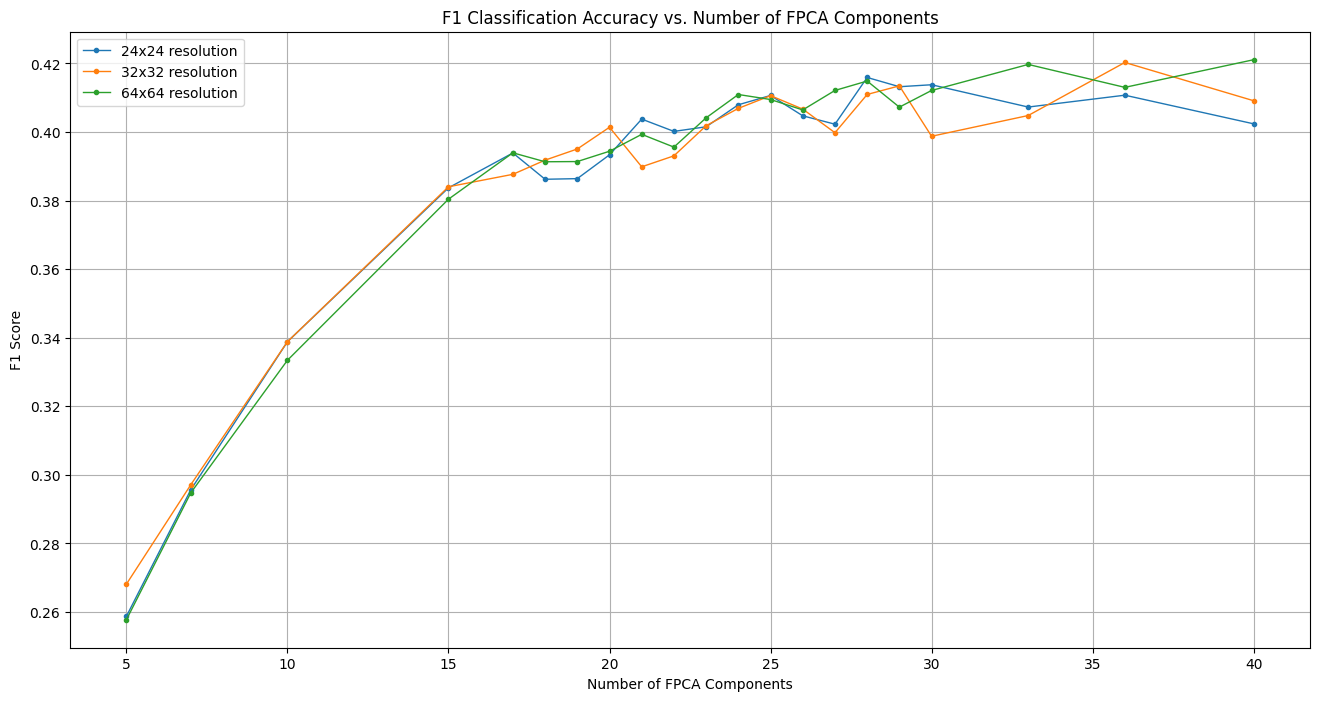

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(acc_list_x, acc_low_list1, 'o-', linewidth=1, markersize=3, label = '24x24 resolution')
plt.plot(acc_list_x, acc_low_list, 'o-', linewidth=1, markersize=3, label = '32x32 resolution')
plt.plot(acc_list_x, acc_list, 'o-', linewidth=1, markersize=3, label = '64x64 resolution')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('F1 Score')
plt.title("F1 Classification Accuracy vs. Number of FPCA Components")
plt.legend()
plt.show()


1.  Below ~5 components, all resolutions show noticeably lower F1-scores. Too few FPCA components cannot capture enough  information for effective classification.

2. Between 5 and 10 components, each resolution curve rises sharply. This set of principal components contain the most critical features for distinguishing classes.

3. Beyond ~15–20 components, improvements become marginal. The curves begin to flatten, indicating diminishing returns from adding more components.


/tmp/ipykernel_5072/941512017.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


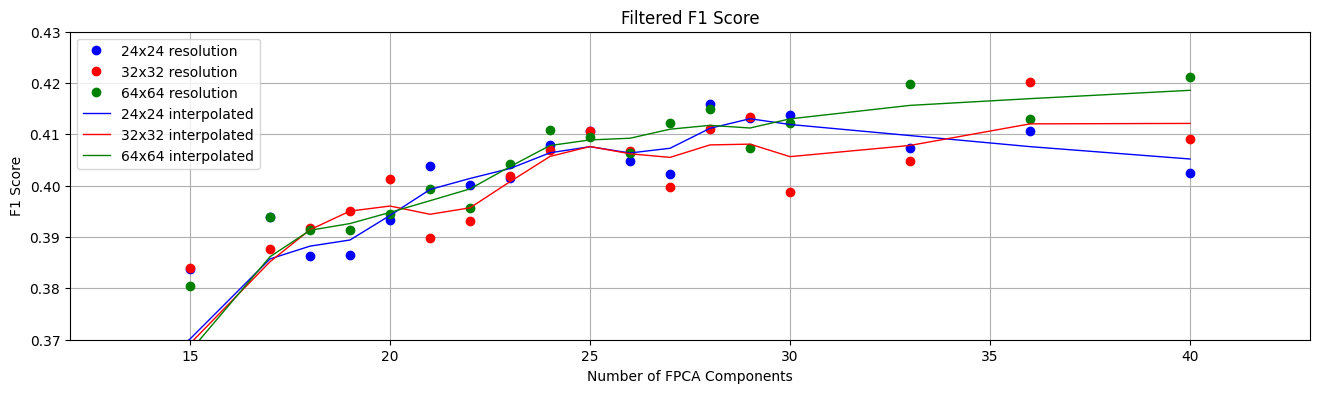

In [21]:
from scipy.ndimage.filters import gaussian_filter1d


plt.figure(figsize=(16, 4))
plt.plot(acc_list_x, acc_low_list1, 'bo',  label = '24x24 resolution')
plt.plot(acc_list_x, acc_low_list, 'ro', label = '32x32 resolution')
plt.plot(acc_list_x, acc_list, 'go',  label = '64x64 resolution')

plt.plot(acc_list_x, gaussian_filter1d(acc_low_list1, sigma=1), 'b', linewidth=1, label = '24x24 interpolated')
plt.plot(acc_list_x, gaussian_filter1d(acc_low_list, sigma=1), 'r', linewidth=1, label = '32x32 interpolated')
plt.plot(acc_list_x, gaussian_filter1d(acc_list, sigma=1), 'g', linewidth=1, label = '64x64 interpolated')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('F1 Score')
plt.title("Filtered F1 Score")
plt.legend()
plt.ylim([0.37, 0.43])
plt.xlim([12, 43])
plt.show()

In [22]:
fpca_low_list[2]

It is hard to distinguish the best number of components to perform classification. All 3 approaches have similar precision and simultaneously reach a plateau. 


Next we will make a closer look at the trained models. Below are several options for metrics and approaches that make it possible to evaluate the quality of FPCA work on the CIFAR-10 dataset. All of them more directly reflect how well FPCA "understands" the data structure or reconstructs images.

In [23]:
'''
import pickle
    
with open('fpca_models24.pkl', 'rb') as f:
    fpca_low_list1 = pickle.load(f)
with open('fpca_models32.pkl', 'rb') as f:
    fpca_low_list = pickle.load(f)
with open('fpca_models64.pkl', 'rb') as f:
    fpca_list = pickle.load(f)
'''
pass

## 10 components

We do not expect a good result here, as the number of main components is bigger. If the dataset is extremely high‐dimensional (thousands of pixels), even 10 principal components may be insufficient.  However, it is intresting to investigate eigenfunctions' evolution.


Eigenfunctions are stored in a flattened format but reshaped for visualization (e.g., reshape(32, 32) or reshape(64, 64)). The 1D plot of eigenfunctions is highly oscillatory, reflecting the large number of pixels (points) per image. These oscillations partly capture local variations in intensity across the image grid. 




In [24]:
n_components = 10

fpca_low = fpca_low_list[2]
scores_low = fpca_low.transform(fdata_low)

fpca_high = fpca_list[2]
scores_high = fpca_high.transform(fdata_high)

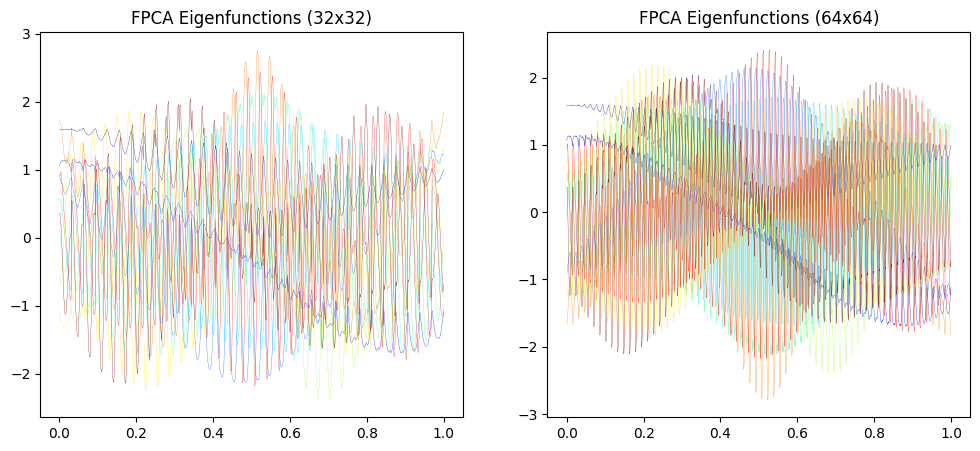

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
kwargs={'lw':0.2}
_ = plot(fpca_low.eigenfunctions, ax = axes[0], **kwargs)
axes[0].set_title("FPCA Eigenfunctions (32x32)")

_ = plot(fpca_high.eigenfunctions, ax = axes[1], **kwargs)
axes[1].set_title("FPCA Eigenfunctions (64x64)")
plt.show()

In the 2D representation, we see that each principal function emphasizes distinct regions of the image. Some components capture broader, low-frequency changes in pixel intensity (e.g., a smooth gradient from top to bottom), while others highlight more localized or high-frequency structures (e.g., bright center vs. darker corners). 

This confirms that FPCA is learning global and local intensity patterns.


In smaller resolutions (like 32x32), the functions are smoother and simpler. At 64x64, there is more freedom for the functions to show details, but there is also more noise. The difference in resolution shows how FPCA can work with different sizes of grids. But the memory and calculation need more when the resolution is higher.

Low resolution


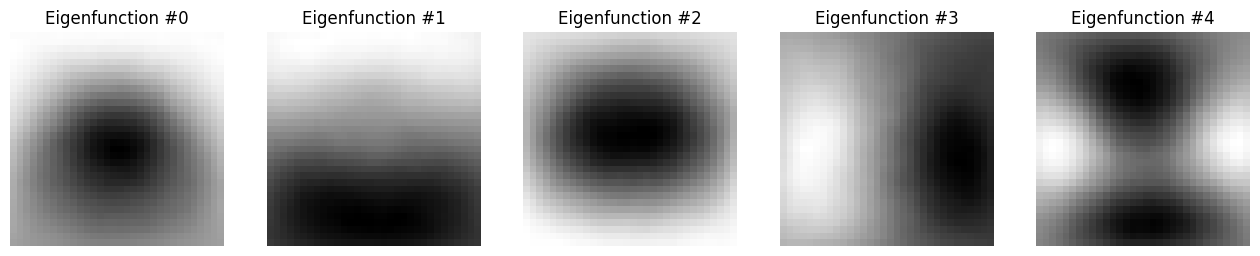

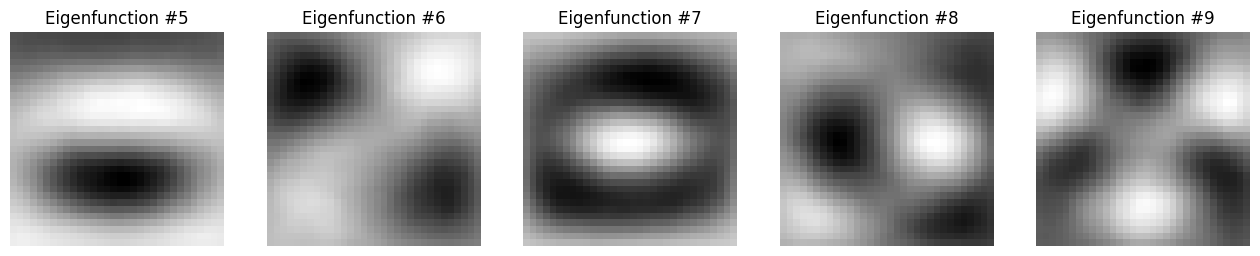

In [26]:
n_axes = 5
print('Low resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_low.eigenfunctions[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[j].set_title("Eigenfunction #" + str(i+j))
        axes[j].axis("off") 
        

High resolution


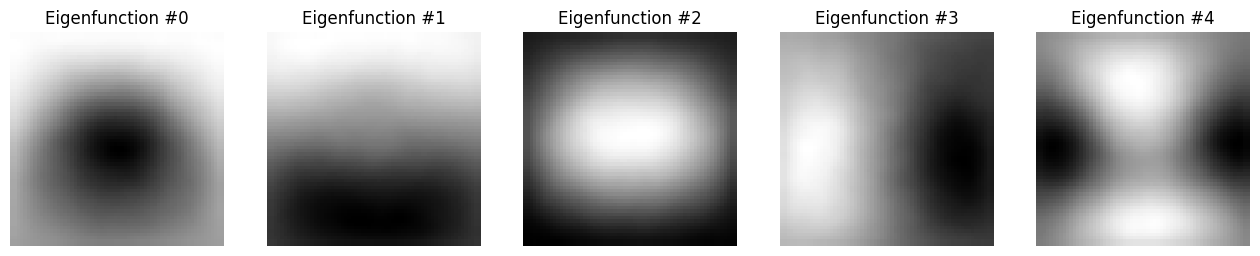

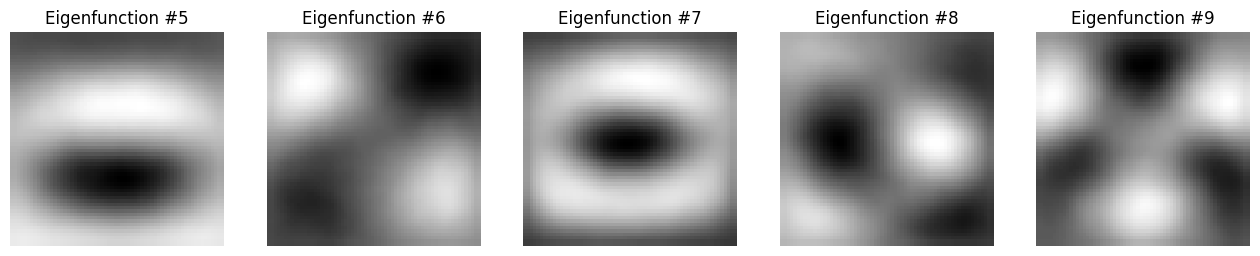

In [27]:
print('High resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_high.eigenfunctions[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[j].set_title("Eigenfunction #" + str(i+j))
        axes[j].axis("off")

It is common to observe inversion in components (2, 4 and 6), because each eigenfunction is defined only up to a sign. Also error from approximation of covariance operator can cause a slight reorder or sign flip in the resulting eigenfunctions. 



Next we evaluate the quality of reconstruction (for example, by MSE) for each set

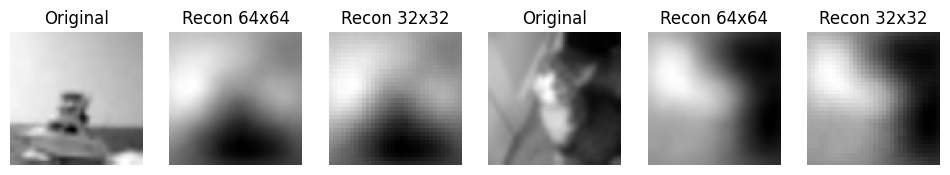

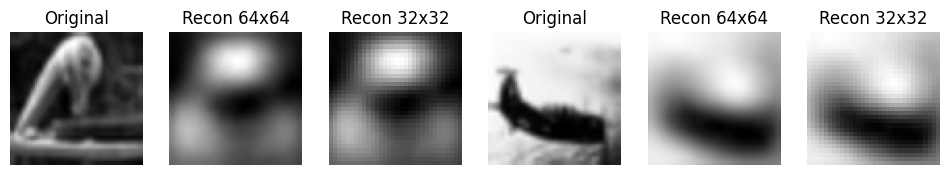

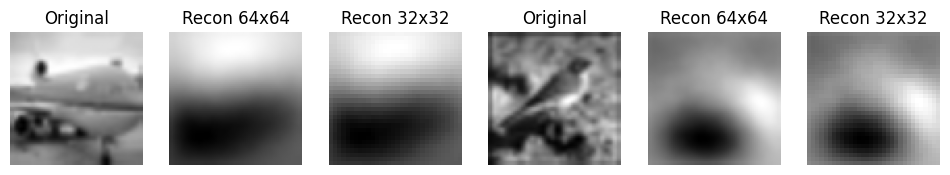

In [28]:
data_recons_low  = fpca_low.inverse_transform(scores_low)
data_recons_high = fpca_high.inverse_transform(scores_high)

recon_low  = data_recons_low.values.data  
recon_high = data_recons_high.values.data 

for i in range(100, 1000, 300):
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for j in range(2):
        axes[3*j].imshow(X_train_high[i+j].reshape(64, 64), cmap='gray')
        axes[3*j].set_title("Original")
        axes[3*j].axis("off")

        axes[3*j+1].imshow(data_recons_high[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[3*j+1].set_title("Recon 64x64")
        axes[3*j+1].axis("off")
        
        axes[3*j+2].imshow(data_recons_low[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[3*j+2].set_title("Recon 32x32")
        axes[3*j+2].axis("off")

1. **Overview of reconstructed dataset**

The reconstructed images using 10 components show that overall structure (shapes, general outlines) of objects is preserved, but fine details are not clear. This happens when using a few PC in a high-dimensional space.


The edges and the lines between light and dark are not so sharp. But the main things are still visible, indicating that these 10 components capture a significant portion of the meaningful variance in the dataset.

2. **Quality of Reconstruction**.

Visually, each reconstructed image retains the general silhouette and main intensity distribution of the original. In many cases, objects (e.g., vehicles, animals) remain identifiable despite the smoothing effect.





In [29]:
from skimage.metrics import structural_similarity as ssim
from math import log10

def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0  
    psnr = 10 * log10((max_pixel ** 2) / mse)
    return mse, psnr

def compute_ssim(img1, img2):
    ssim_total = 0
    for i in range(len(img1)):
        tmp = img2[i].to_long().values[:, 2]
        ssim_total+=ssim(img1[i], tmp, data_range=1.0)
    return ssim_total/len(img1)


        
mse_low, psnr_value = compute_psnr(X_train_low, recon_low)
ssim_value = compute_ssim(X_train_low, data_recons_low)
print("10 components\n32x32 PSNR:", psnr_value)
print("32x32 SSIM:", ssim_value)
print(f"32x32 MSE: {mse_low:.4f}\n")

mse_high, psnr_value = compute_psnr(X_train_high, recon_high)
ssim_value = compute_ssim(X_train_high, data_recons_high)
print("64x64 PSNR:", psnr_value)
print("64x64 SSIM:", ssim_value)
print(f"64x64 MSE: {mse_high:.4f}")


10 components
32x32 PSNR: 17.406899244001686
32x32 SSIM: 0.37081717871503656
32x32 MSE: 0.0182

64x64 PSNR: 18.184259561616166
64x64 SSIM: 0.5089341179244127
64x64 MSE: 0.0152


## 20 components

In [30]:
n_components = 20

fpca_low = fpca_low_list[7]
scores_low = fpca_low.transform(fdata_low)

fpca_high = fpca_list[7]
scores_high = fpca_high.transform(fdata_high)

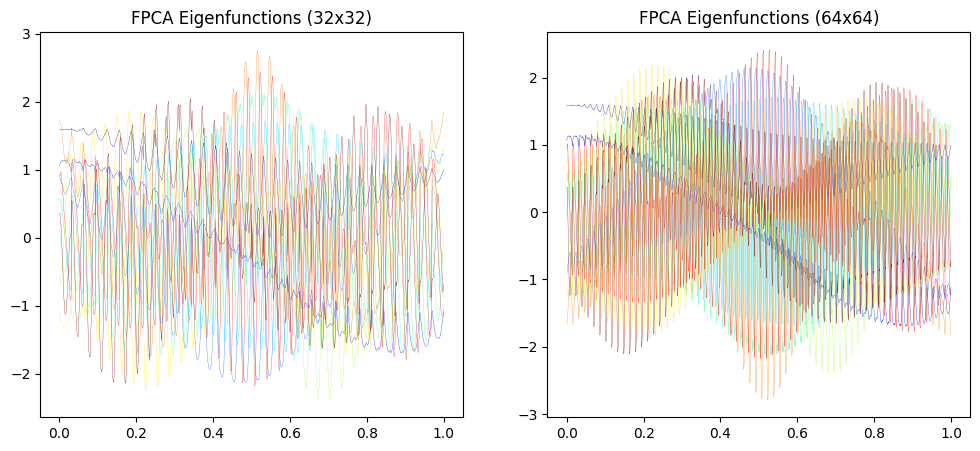

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
kwargs={'lw':0.2}
_ = plot(fpca_low.eigenfunctions[:10], ax = axes[0], **kwargs)
axes[0].set_title("FPCA Eigenfunctions (32x32)")

_ = plot(fpca_high.eigenfunctions[:10], ax = axes[1], **kwargs)
axes[1].set_title("FPCA Eigenfunctions (64x64)")
plt.show()

Low resolution


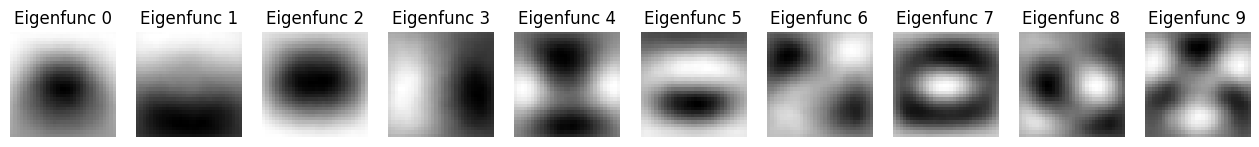

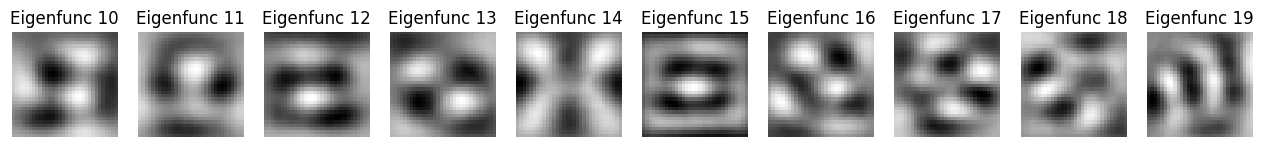

In [32]:
n_axes = 10
print('Low resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_low.eigenfunctions[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[j].set_title("Eigenfunc " + str(i+j))
        axes[j].axis("off") 
        

High resolution


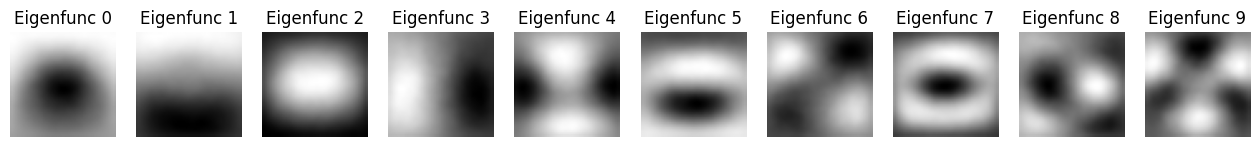

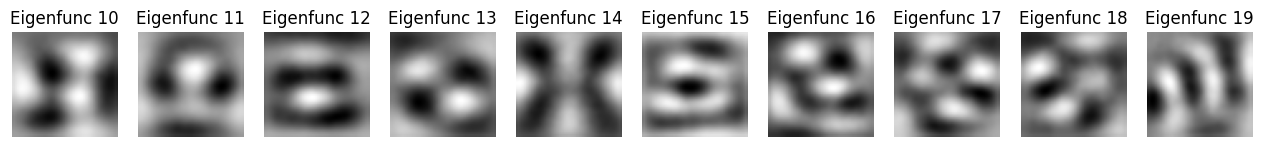

In [33]:
n_axes = 10
print('High resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_high.eigenfunctions[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[j].set_title("Eigenfunc " + str(i+j))
        axes[j].axis("off") 
        

Here we can see, that the first 10 eigenfunctions remain the same as for 10 components. They focus on broad intensity gradients and main structural features. 

However, additional 10 eigenfunctions represent more complex features, which are crucial for classification improvement. Higher-index eigenfunctions often highlight small, localized regions or subtle edges. This underscores how FPCA progressively captures different scales of variation.

Also features for high and low resolution remain the same, despite some invertions (14, 15, 18)

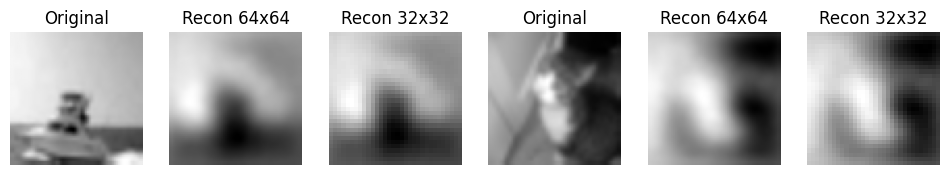

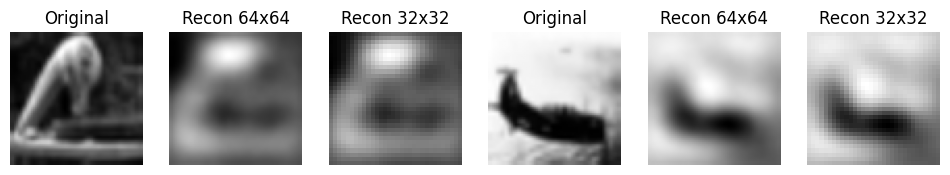

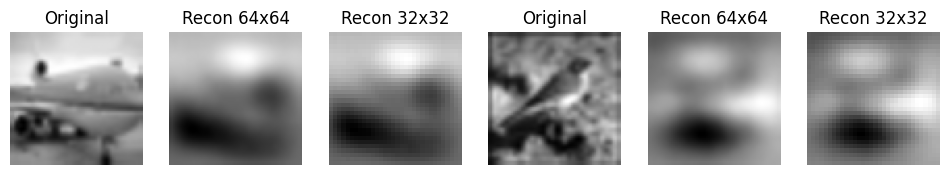

In [34]:
data_recons_low  = fpca_low.inverse_transform(scores_low)
data_recons_high = fpca_high.inverse_transform(scores_high)

recon_low  = data_recons_low.values.data  
recon_high = data_recons_high.values.data 

for i in range(100, 1000, 300):
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for j in range(2):
        axes[3*j].imshow(X_train_high[i+j].reshape(64, 64), cmap='gray')
        axes[3*j].set_title("Original")
        axes[3*j].axis("off")

        axes[3*j+1].imshow(data_recons_high[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[3*j+1].set_title("Recon 64x64")
        axes[3*j+1].axis("off")
        
        axes[3*j+2].imshow(data_recons_low[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[3*j+2].set_title("Recon 32x32")
        axes[3*j+2].axis("off")

In [35]:
mse_low, psnr_value = compute_psnr(X_train_low, recon_low)
ssim_value = compute_ssim(X_train_low, data_recons_low)
print("20 components\n32x32 PSNR:", psnr_value)
print("32x32 SSIM:", ssim_value)
print(f"32x32 MSE: {mse_low:.4f}\n")

mse_high, psnr_value = compute_psnr(X_train_high, recon_high)
ssim_value = compute_ssim(X_train_high, data_recons_high)
print("64x64 PSNR:", psnr_value)
print("64x64 SSIM:", ssim_value)
print(f"64x64 MSE: {mse_high:.4f}")

20 components
32x32 PSNR: 18.83000316890277
32x32 SSIM: 0.4403720176091843
32x32 MSE: 0.0131

64x64 PSNR: 19.876302373525256
64x64 SSIM: 0.5457482508578514
64x64 MSE: 0.0103


1. **Reconstruction and MSE:**

MSE scores are slightly lower than in the 10-component case. At 64×64, the lower MSE confirms that the extra 10 components help capture additional detail.

The reconstructed images are less blur, especially in areas with moderate texture. 


2. **Visual Comparison:**

For both 32×32 and 64×64, the objects (boats, animals, etc.) exhibit more recognizable contours than with fewer components. The difference is especially noticeable around edges and textured regions in the 64×64 set.



## 30 components

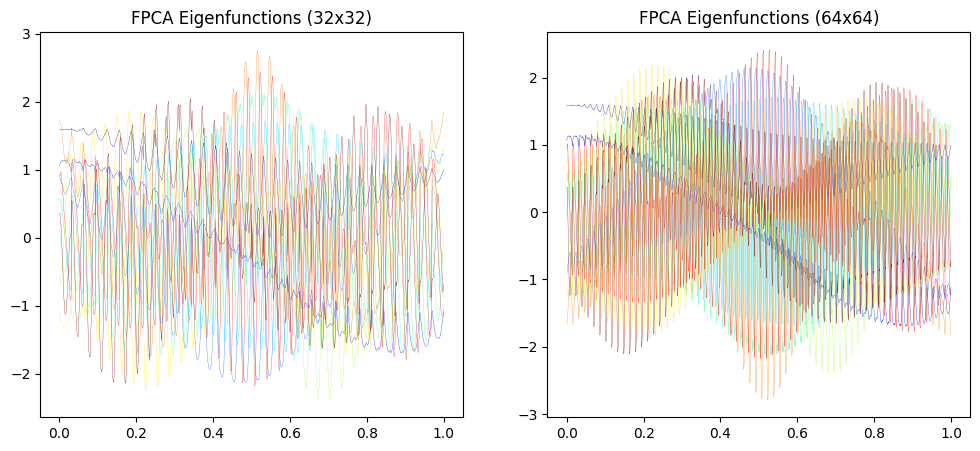

In [36]:
n_components = 30

fpca_low = fpca_low_list[17]
scores_low = fpca_low.transform(fdata_low)

fpca_high = fpca_list[17]
scores_high = fpca_high.transform(fdata_high)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
kwargs={'lw':0.2}
_ = plot(fpca_low.eigenfunctions[:10], ax = axes[0], **kwargs)
axes[0].set_title("FPCA Eigenfunctions (32x32)")

_ = plot(fpca_high.eigenfunctions[:10], ax = axes[1], **kwargs)
axes[1].set_title("FPCA Eigenfunctions (64x64)")
plt.show()

Low resolution


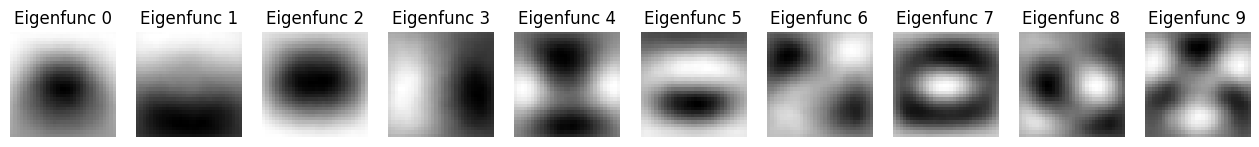

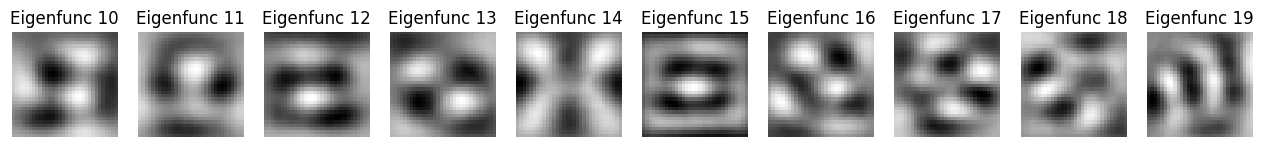

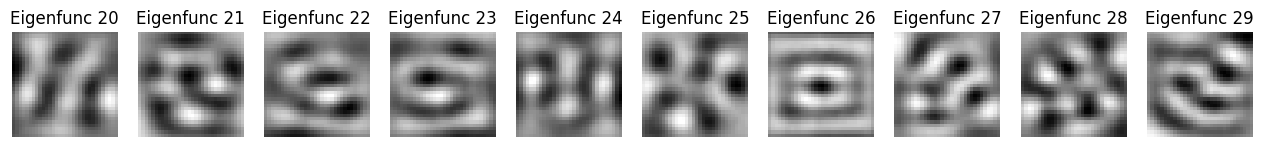

In [37]:
n_axes = 10
print('Low resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_low.eigenfunctions[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[j].set_title("Eigenfunc " + str(i+j))
        axes[j].axis("off") 
        

High resolution


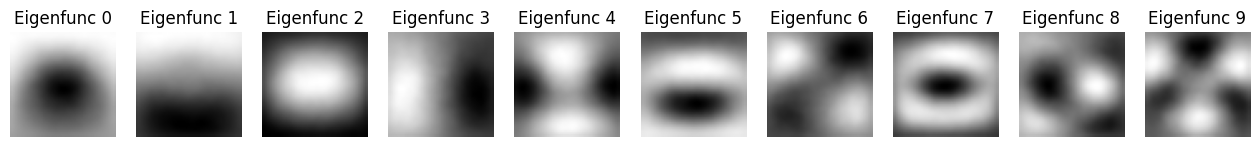

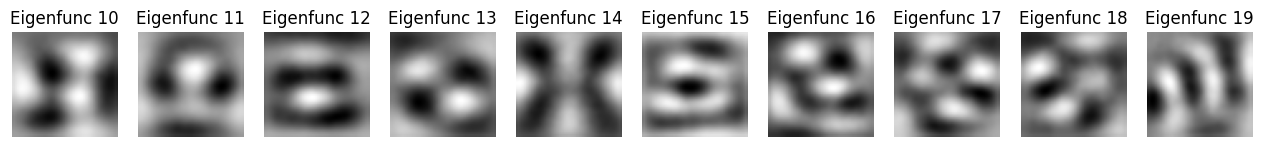

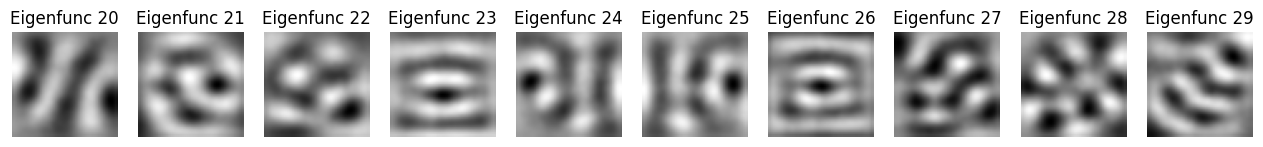

In [38]:
n_axes = 10
print('High resolution')
for i in range(0, n_components, n_axes):
    fig, axes = plt.subplots(1, n_axes, figsize=(16, 3))
    for j in range(n_axes):
        axes[j].imshow(fpca_high.eigenfunctions[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[j].set_title("Eigenfunc " + str(i+j))
        axes[j].axis("off") 
        

Model continues to recognize complex features, but they don't play much role in classification task. Each following eigenfunction represents more sophisticated feature.

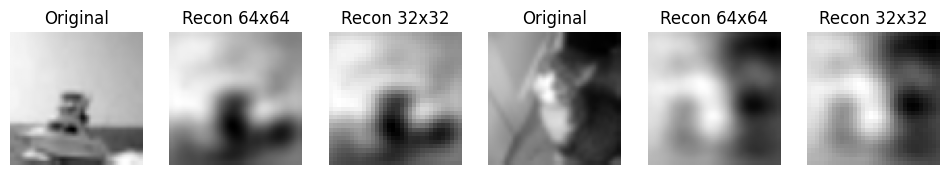

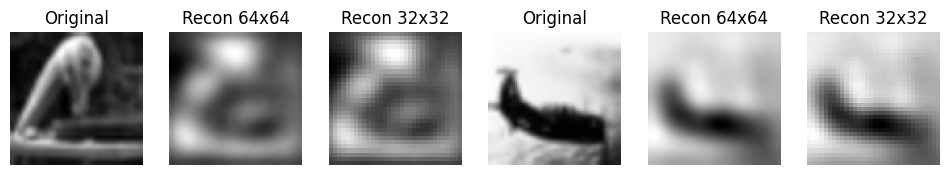

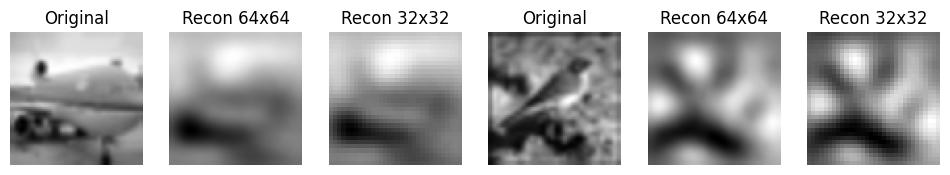

In [39]:
data_recons_low  = fpca_low.inverse_transform(scores_low)
data_recons_high = fpca_high.inverse_transform(scores_high)

recon_low  = data_recons_low.values.data  
recon_high = data_recons_high.values.data 

for i in range(100, 1000, 300):
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for j in range(2):
        axes[3*j].imshow(X_train_high[i+j].reshape(64, 64), cmap='gray')
        axes[3*j].set_title("Original")
        axes[3*j].axis("off")

        axes[3*j+1].imshow(data_recons_high[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[3*j+1].set_title("Recon 64x64")
        axes[3*j+1].axis("off")
        
        axes[3*j+2].imshow(data_recons_low[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[3*j+2].set_title("Recon 32x32")
        axes[3*j+2].axis("off")

In [40]:
mse_low, psnr_value = compute_psnr(X_train_low, recon_low)
ssim_value = compute_ssim(X_train_low, data_recons_low)
print("30 components\n32x32 PSNR:", psnr_value)
print("32x32 SSIM:", ssim_value)
print(f"32x32 MSE: {mse_low:.4f}\n")

mse_high, psnr_value = compute_psnr(X_train_high, recon_high)
ssim_value = compute_ssim(X_train_high, data_recons_high)
print("64x64 PSNR:", psnr_value)
print("64x64 SSIM:", ssim_value)
print(f"64x64 MSE: {mse_high:.4f}")

30 components
32x32 PSNR: 19.774218819399337
32x32 SSIM: 0.4883359245213191
32x32 MSE: 0.0105

64x64 PSNR: 21.0283976472833
64x64 SSIM: 0.5749525234369165
64x64 MSE: 0.0079


1. **Eigenfunctions** - less interpretable, sophisticated features.

At 30 components, the FPCA basis captures many nuanced features. However, these higher‐order eigenfunctions often become more specialized and less impactful for broad classification tasks.


Both low and high resolution sets share the same fundamental modes in the first ~10–15 components. The extra components (from ~16 to 30) mainly refine local or high‐frequency details, which marginally affects classification performance.

2. **Reconstruction**

Reconstructed images with 30 components show slightly sharper details than with 10 or 20 components, but the improvement tapers off. This indicates that most meaningful variance is captured by the first ~20 components, while later ones target minor variations or noise.


Also 30 components offer a more complete representation of the image space, classification accuracy saturates before reaching 30 (near 20)


### 40 components

Just for curiousity. Reconstructed images with 40 components obviously show slightly sharper details.

40 components
32x32 PSNR: 20.507173856432065
32x32 SSIM: 0.5302531010837476
32x32 MSE: 0.0089

64x64 PSNR: 21.94841883155844
64x64 SSIM: 0.6029145935557213
64x64 MSE: 0.0064


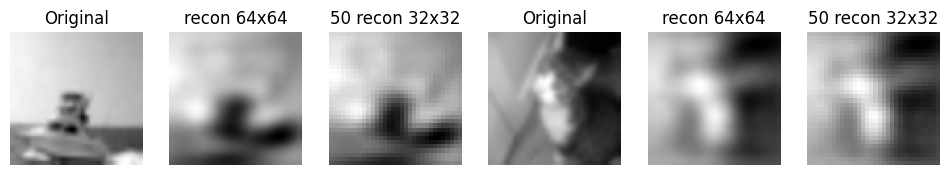

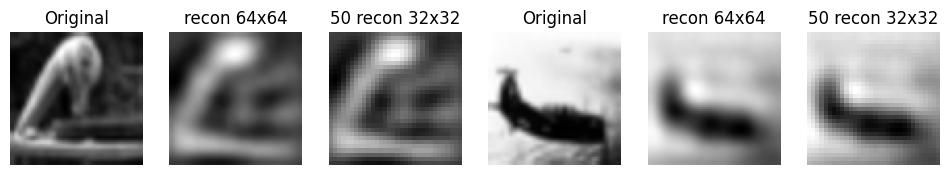

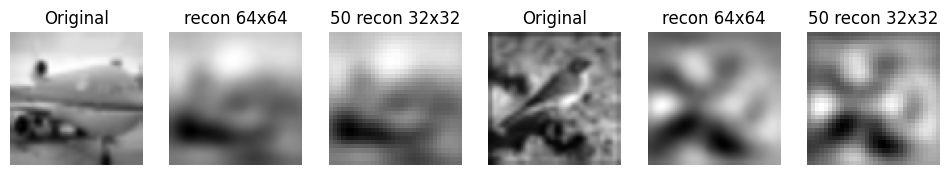

In [41]:
fpca_low = fpca_low_list[-1]
scores_low = fpca_low.transform(fdata_low)

fpca_high = fpca_list[-1]
scores_high = fpca_high.transform(fdata_high)

data_recons_low  = fpca_low.inverse_transform(scores_low)
data_recons_high = fpca_high.inverse_transform(scores_high)

recon_low  = data_recons_low.values.data  
recon_high = data_recons_high.values.data 

mse_low, psnr_value = compute_psnr(X_train_low, recon_low)
ssim_value = compute_ssim(X_train_low, data_recons_low)
print("40 components\n32x32 PSNR:", psnr_value)
print("32x32 SSIM:", ssim_value)
print(f"32x32 MSE: {mse_low:.4f}\n")

mse_high, psnr_value = compute_psnr(X_train_high, recon_high)
ssim_value = compute_ssim(X_train_high, data_recons_high)
print("64x64 PSNR:", psnr_value)
print("64x64 SSIM:", ssim_value)
print(f"64x64 MSE: {mse_high:.4f}")

for i in range(100, 1000, 300):
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for j in range(2):
        axes[3*j].imshow(X_train_high[i+j].reshape(64, 64), cmap='gray')
        axes[3*j].set_title("Original")
        axes[3*j].axis("off")

        axes[3*j+1].imshow(data_recons_high[i+j].to_long().values[:, 2].reshape(64, 64), cmap='gray')
        axes[3*j+1].set_title("recon 64x64")
        axes[3*j+1].axis("off")
        
        axes[3*j+2].imshow(data_recons_low[i+j].to_long().values[:, 2].reshape(32, 32), cmap='gray')
        axes[3*j+2].set_title("50 recon 32x32")
        axes[3*j+2].axis("off")

Reconstruction metrics (MSE, PSNR, SSIM) measure how well FPCA recovers the original image.

- PSNR (Peak Signal-to-Noise Ratio) - commonly used to quantify reconstruction quality for images and video subject to lossy compression. 
$$
\text{PSNR}(X, \hat X) = 10\log_10\left(\frac{\max(X)^2}{\text{MSE}(X, \hat X)}\right)
$$
- SSIM  (Structural Similarity Index) - perceptual metric that quantifies image quality degradation caused by processing such as data compression or by losses in data transmission.
$$
\text{SSIM}(X, \hat X) = \frac{(2\mu_X\mu_{\hat X} + C_1)(2\sigma_{X\hat X} + C_2)}{(\mu_X^2 + \mu_{\hat X}^2 + C_1)(\sigma_X^2 + \sigma_{\hat X}^2 + C_12},
$$
Where $\mu_X$ and $\sigma_X^2$ - mean and std, $\sigma_{X\hat X}$ - covariation, $C_1$ and $C_2$ - constants. Better reflects visual similarity, considers brightness, contrast and structure.


\begin{array}{c|ccc|ccc}
\textbf{nComp} & \textbf{PSNR}_{32\times 32} & \textbf{SSIM}_{32\times 32} & \textbf{MSE}_{32\times 32} & \textbf{PSNR}_{64\times 64} & \textbf{SSIM}_{64\times 64} & \textbf{MSE}_{64\times 64}\\
\hline
10 & 17.4069 & 0.3708 & 0.0182 & 18.1843 & 0.5089 & 0.0152 \\
20 & 18.8300 & 0.4404 & 0.0131 & 19.8763 & 0.5457 & 0.0103 \\
30 & 19.7742 & 0.4883 & 0.0105 & 21.0284 & 0.5749 & 0.0079 \\
40 & 20.5072 & 0.5303 & 0.0089 & 21.9484 & 0.6029 & 0.0064 \\
\end{array}



Here we can see that reconstruction quality continues to grow. Let's have a look how quality depends on number of components.

## Reconstruction accuracy
Here is an illustration that increasing number of components only helps restore initial images, because MSE decreases even on the big values of n_components.

0 5
1 7
2 10
3 15
4 17
5 18
6 19
7 20
8 21
9 22
10 23
11 24
12 25
13 26
14 27
15 28
16 29
17 30
18 33
19 36
20 40


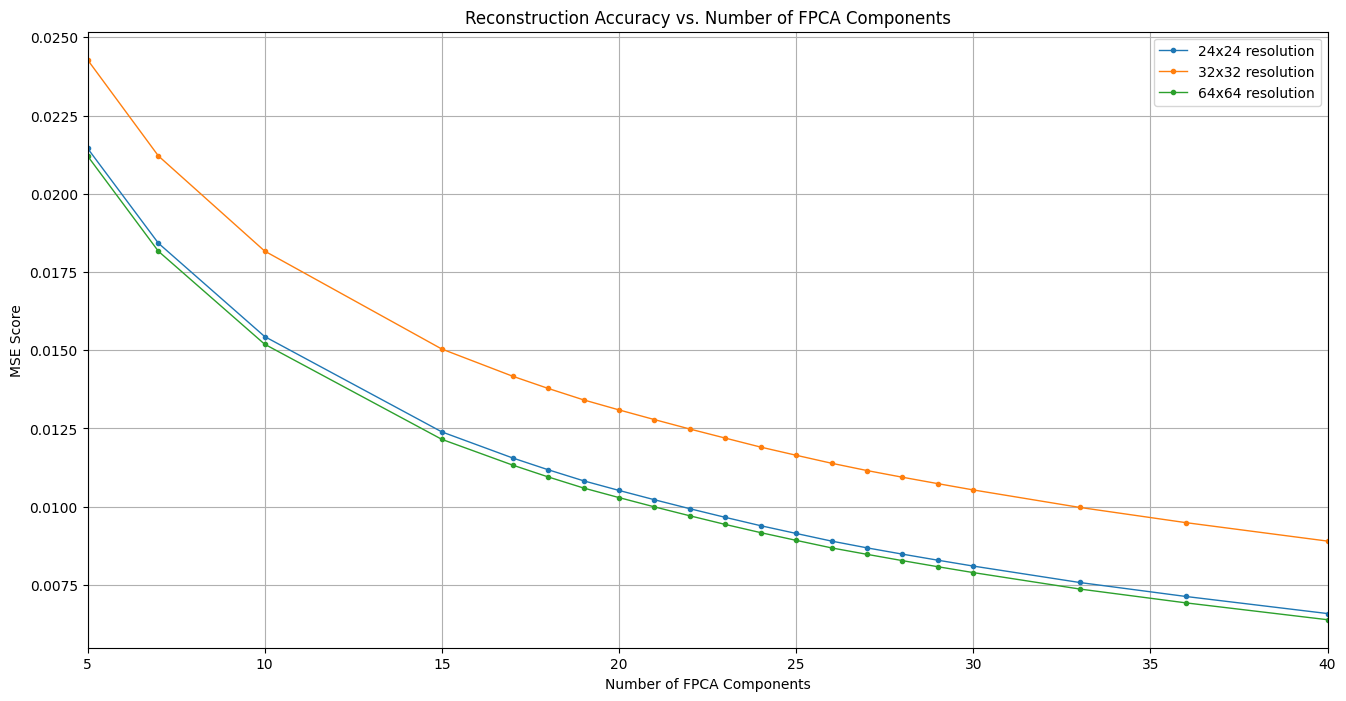

In [42]:
mse_high_list = []
mse_low_list = []
mse_low_list1 = []
for i in range(len(acc_list_x)):
    print(i, acc_list_x[i])
    fpca_low = fpca_low_list1[i]
    scores_low = fpca_low.transform(fdata_low1)
    data_recons_low  = fpca_low.inverse_transform(scores_low)
    recon_low  = data_recons_low.values.data  
    mse_low  = np.mean((X_train_low1  - recon_low) ** 2)
    mse_low_list1.append(mse_low)
    
    fpca_low = fpca_low_list[i]
    scores_low = fpca_low.transform(fdata_low)
    data_recons_low  = fpca_low.inverse_transform(scores_low)
    recon_low  = data_recons_low.values.data  
    mse_low  = np.mean((X_train_low  - recon_low) ** 2)
    mse_low_list.append(mse_low)
    #print(f"MSE reconstruct (32x32): {mse_low:.4f}",'\t num components = '+ str(acc_list_x[i]))
    
    fpca_high = fpca_list[i]
    scores_high = fpca_high.transform(fdata_high)
    data_recons_high = fpca_high.inverse_transform(scores_high)
    recon_high = data_recons_high.values.data 
    mse_high = np.mean((X_train_high - recon_high) ** 2)
    mse_high_list.append(mse_high)
    #print(f"MSE reconstruct (64x64): {mse_high:.4f}",'\t num components = '+ str(acc_list_x1[i]))
    
    
plt.figure(figsize=(16, 8))
plt.plot(acc_list_x, mse_low_list1, 'o-', linewidth=1, markersize=3, label = '24x24 resolution')
plt.plot(acc_list_x, mse_low_list, 'o-', linewidth=1, markersize=3, label = '32x32 resolution')
plt.plot(acc_list_x, mse_high_list, 'o-', linewidth=1, markersize=3, label = '64x64 resolution')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('MSE Score')
plt.title("Reconstruction Accuracy vs. Number of FPCA Components")
plt.legend()
plt.xlim([5, 40])
plt.show()



### Alternative 

SSIM is used to compare the structural similarity between the original and reconstructed images. It considers luminance, contrast, and structure, making it more aligned with human perception compared to simple pixel-wise errors.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from FDApy.preprocessing import UFPCA


ssim24_list = []
psnr24_list = []
ssim32_list = []
psnr32_list = []
ssim64_list = []
psnr64_list = []

def compute_avg_ssim(orig, recon, img_shape):
    orig_np = np.array(orig)
    recon_np = np.array(recon)
    
    ssim_values = []
    for i in range(orig_np.shape[0]):
        orig_img = orig_np[i].reshape(img_shape)
        recon_img = recon_np[i].reshape(img_shape)
        ssim_val = ssim(orig_img, recon_img, data_range=recon_img.max()-recon_img.min())
        ssim_values.append(ssim_val)
    return np.mean(ssim_values)

for i in range(len(acc_list_x)):
    #----------------------24x24--------------------------------
    fpca_low = fpca_low_list1[i]
    X_train_fpca = fpca_low.transform(fdata_low1)
    X_test_fpca  = fpca_low.transform(fdata_low_test1)
    data_recons = fpca_low.inverse_transform(X_test_fpca)
    
    # Extract original and reconstructed data (flattened)
    X_test_orig = fdata_low_test1.values.data 
    X_test_recons = data_recons.values.data
    
    # Compute average SSIM over the test set (reshape each image to img_dim x img_dim)
    avg_ssim = compute_avg_ssim(X_test_orig, X_test_recons, (24, 24))
    _, psnr_value = compute_psnr(X_test_low1, X_test_recons)
    ssim24_list.append(avg_ssim)
    psnr24_list.append(psnr_value)
    
    #----------------------32x32--------------------------------
    fpca_low = fpca_low_list[i]
    X_train_fpca = fpca_low.transform(fdata_low)
    X_test_fpca  = fpca_low.transform(fdata_low_test)
    data_recons = fpca_low.inverse_transform(X_test_fpca)
    
    # Extract original and reconstructed data (flattened)
    X_test_orig = fdata_low_test.values.data 
    X_test_recons = data_recons.values.data
    
    # Compute average SSIM over the test set (reshape each image to img_dim x img_dim)
    avg_ssim = compute_avg_ssim(X_test_orig, X_test_recons, (32, 32))
    _, psnr_value = compute_psnr(X_test_low, X_test_recons)
    ssim32_list.append(avg_ssim)
    psnr32_list.append(psnr_value)
    
    #----------------------64x64--------------------------------
    fpca_high = fpca_list[i]
    X_train_fpca = fpca_high.transform(fdata_high)
    X_test_fpca  = fpca_high.transform(fdata_high_test)
    data_recons = fpca_high.inverse_transform(X_test_fpca)
    
    # Extract original and reconstructed data (flattened)
    X_test_orig = fdata_high_test.values.data 
    X_test_recons = data_recons.values.data
    
    # Compute average SSIM over the test set (reshape each image to img_dim x img_dim)
    avg_ssim = compute_avg_ssim(X_test_orig, X_test_recons, (64, 64))
    _, psnr_value = compute_psnr(X_test_high, X_test_recons)
    ssim64_list.append(avg_ssim)
    psnr64_list.append(psnr_value)
    
    print(i, psnr64_list[-1], psnr32_list[-1], psnr24_list[-1])
    #print(f"MSE reconstruct (32x32): {mse_low:.4f}",'\t num components = '+ str(acc_list_x[i]))



0 16.782327830220822 16.193148152993835 16.733002381173584
1 17.43285466367987 16.761485785412027 17.37253016365819
2 18.19862892171139 17.42520684261136 18.130436684824115
3 19.166394745163934 18.244437435757966 19.08287744601488
4 19.46940362261586 18.500706348642314 19.38365369746447
5 19.608865439716915 18.616053496558514 19.520421220059436
6 19.759581972909814 18.739077008139734 19.66777795196224
7 19.888164754821908 18.844775843779775 19.7940597949408
8 20.013217586244938 18.946279693503563 19.915786134999113
9 20.13797898381089 19.049967779036017 20.038776095587288
10 20.25851232158818 19.14452865624376 20.15535600301368
11 20.374325487748376 19.245183052230615 20.271448401288758
12 20.49150441209074 19.338355508012686 20.383111937282056
13 20.61039887929747 19.436900243486285 20.503995410673514
14 20.714511157635947 19.527768836594703 20.612172171200207
15 20.823607546229876 19.61433185111777 20.718814314158415
16 20.927878446564286 19.69746552489956 20.81989077766599
17 21.027

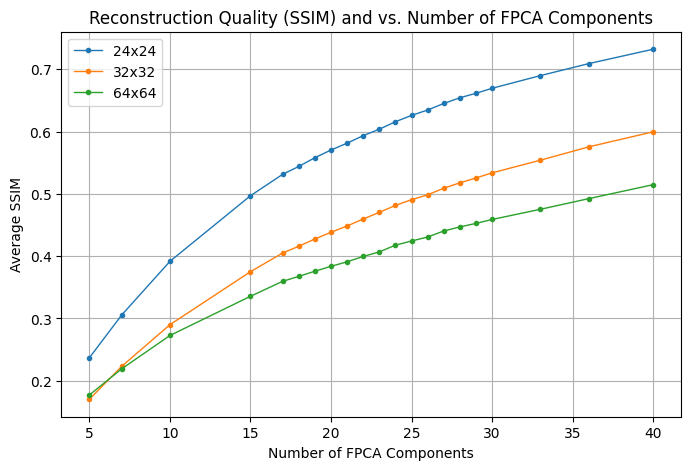

In [44]:
# Plot the average SSIM as a function of the number of FPCA components
plt.figure(figsize=(8, 5))
plt.plot(acc_list_x, ssim24_list, 'o-', linewidth=1, markersize=3, label='24x24')
plt.plot(acc_list_x, ssim32_list, 'o-', linewidth=1, markersize=3, label='32x32')
plt.plot(acc_list_x, ssim64_list, 'o-', linewidth=1, markersize=3, label='64x64')
#plt.plot(acc_list_x, psnr_list, 'o-', linewidth=2, markersize=8, label='PSNR')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('Average SSIM')
plt.legend()
plt.title('Reconstruction Quality (SSIM) and vs. Number of FPCA Components')
plt.show()

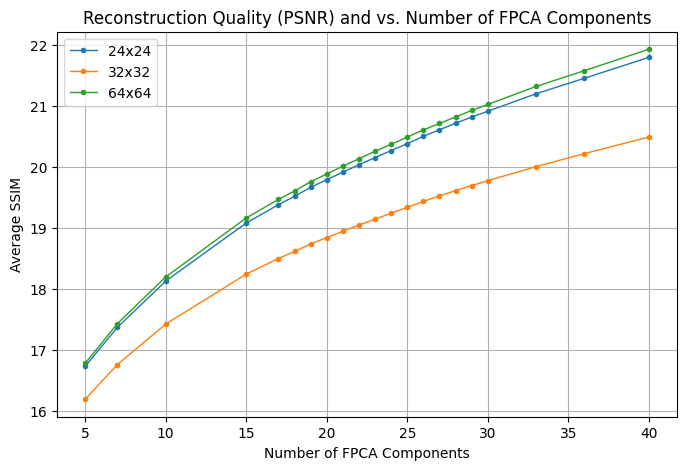

In [45]:
# Plot the average SSIM as a function of the number of FPCA components
plt.figure(figsize=(8, 5))
plt.plot(acc_list_x, psnr24_list, 'o-', linewidth=1, markersize=3, label='24x24')
plt.plot(acc_list_x, psnr32_list, 'o-', linewidth=1, markersize=3, label='32x32')
plt.plot(acc_list_x, psnr64_list, 'o-', linewidth=1, markersize=3, label='64x64')
plt.legend()
#plt.plot(acc_list_x, psnr_list, 'o-', linewidth=2, markersize=8, label='PSNR')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('Average SSIM')
plt.title('Reconstruction Quality (PSNR) and vs. Number of FPCA Components')
plt.show()

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


# 1 XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_low, y_train)
y_pred_xgb = xgb_clf.predict(X_test_low)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb  = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_xgb, f1_xgb))

# 2 CatBoost Classifier
cat_clf = CatBoostClassifier(verbose=0, random_state=42)
cat_clf.fit(X_train_low, y_train)
y_pred_cat = cat_clf.predict(X_test_low)
acc_cat = accuracy_score(y_test, y_pred_cat)
f1_cat  = f1_score(y_test, y_pred_cat, average='weighted')
print("CatBoost - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_cat, f1_cat))

# 3 MLPClassifier from scikit-learn
mlp_clf = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=200, random_state=42)
mlp_clf.fit(X_train_low, y_train)
y_pred_mlp = mlp_clf.predict(X_test_low)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
f1_mlp  = f1_score(y_test, y_pred_mlp, average='weighted')
print("MLPClassifier - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_mlp, f1_mlp))




/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:53:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.4293, Weighted F1-score: 0.4273
CatBoost - Accuracy: 0.4557, Weighted F1-score: 0.4527


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier - Accuracy: 0.3527, Weighted F1-score: 0.3522


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# 1 XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_high, y_train)
y_pred_xgb = xgb_clf.predict(X_test_high)
acc_xgb_high = accuracy_score(y_test, y_pred_xgb)
f1_xgb_high  = f1_score(y_test, y_pred_xgb, average='weighted')
print("XGBoost - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_xgb_high, f1_xgb_high))

# 2 CatBoost Classifier
cat_clf = CatBoostClassifier(verbose=0, random_state=42, task_type="GPU", devices='0')
cat_clf.fit(X_train_high, y_train)
y_pred_cat = cat_clf.predict(X_test_high)
acc_cat_high = accuracy_score(y_test, y_pred_cat)
f1_cat_high  = f1_score(y_test, y_pred_cat, average='weighted')
print("CatBoost - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_cat_high, f1_cat_high))


# 3 MLPClassifier from scikit-learn
mlp_clf = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=200, random_state=42)
mlp_clf.fit(X_train_high, y_train)
y_pred_mlp = mlp_clf.predict(X_test_high)
acc_mlp_high = accuracy_score(y_test, y_pred_mlp)
f1_mlp_high  = f1_score(y_test, y_pred_mlp, average='weighted')
print("MLPClassifier - Accuracy: {:.4f}, Weighted F1-score: {:.4f}".format(acc_mlp_high, f1_mlp_high))


XGBoost - Accuracy: 0.4113, Weighted F1-score: 0.4099
CatBoost - Accuracy: 0.4457, Weighted F1-score: 0.4427
MLPClassifier - Accuracy: 0.3367, Weighted F1-score: 0.3365


In [14]:
f1_xgb = 0.4273
f1_cat = 0.4527
f1_mlp = 0.3522

f1_xgb_high = 0.4099
f1_cat_high = 0.4427
f1_mlp_high = 0.3365

## Alternative classifiers
Below we apply other classifiers instead of SVC to evaluate classification potential of FPCA transformation:
- MLPClassifier from scikit-learn, a simple NN baseline.
- CatBoost
- tuned XGBoost


For each tested number of FPCA components (from 5 up to 40), we fit the FPCA model on the low-resolution training data, transform both training and test datasets into FPCA features, and then use these features as input to our MLP.

### MLPClassifier

Classifiers like SVC or simple MLPs may underperform on image data due to their inability to fully capture non-linearities. However, it is intresting to see if FPCA approach works better with such models.


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

MLPf1_scores24 = []
MLPf1_scores32 = []
MLPf1_scores64 = []
acc_list_x = [5, 7, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 36, 40]
for i in range(len(acc_list_x)):
    # Apply FPCA on low-resolution functional data
    fpca_low = fpca_low_list1[i]
    X_train_fpca = fpca_low.transform(fdata_low1)
    X_test_fpca  = fpca_low.transform(fdata_low_test1)
    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    MLPf1_scores24.append(f1)    
    
    # -----------------32------------------
    fpca_low = fpca_low_list[i]
    X_train_fpca = fpca_low.transform(fdata_low)
    X_test_fpca  = fpca_low.transform(fdata_low_test)
    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    MLPf1_scores32.append(f1)    
    
    # -----------------64------------------
    fpca_high = fpca_list[i]
    X_train_fpca = fpca_high.transform(fdata_high)
    X_test_fpca  = fpca_high.transform(fdata_high_test)
    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"High res: F1-score with {acc_list_x[i]} FPCA components: {f1:.4f}")
    MLPf1_scores64.append(f1)    


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 5 FPCA components: 0.2783


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 7 FPCA components: 0.3116


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 10 FPCA components: 0.3442


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 15 FPCA components: 0.3748


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 17 FPCA components: 0.3692


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 18 FPCA components: 0.3810


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 19 FPCA components: 0.3718


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 20 FPCA components: 0.3666


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 21 FPCA components: 0.3679


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 22 FPCA components: 0.3792


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 23 FPCA components: 0.3817


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 24 FPCA components: 0.3843


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 25 FPCA components: 0.3712


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 26 FPCA components: 0.3732


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 27 FPCA components: 0.3761


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 28 FPCA components: 0.3893


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 29 FPCA components: 0.3843


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 30 FPCA components: 0.3841


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 33 FPCA components: 0.3844


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 36 FPCA components: 0.3848


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached an

High res: F1-score with 40 FPCA components: 0.3864


/home/anita/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


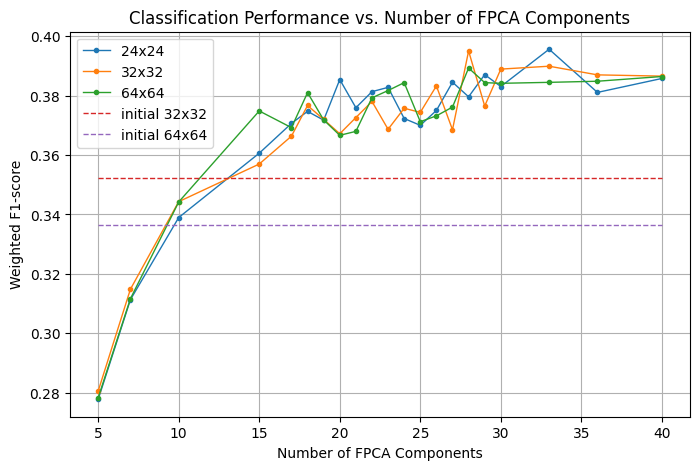

In [15]:
# Plot the average SSIM as a function of the number of FPCA components
plt.figure(figsize=(8, 5))
plt.plot(acc_list_x, MLPf1_scores24, 'o-', linewidth=1, markersize=3, label='24x24')
plt.plot(acc_list_x, MLPf1_scores32, 'o-', linewidth=1, markersize=3, label='32x32')
plt.plot(acc_list_x, MLPf1_scores64, 'o-', linewidth=1, markersize=3, label='64x64')

plt.plot([5,40], [f1_mlp, f1_mlp] , '--', linewidth=1, label='initial 32x32')
plt.plot([5,40], [f1_mlp_high, f1_mlp_high], '--', linewidth=1, label='initial 64x64')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('Weighted F1-score')
plt.legend()
plt.title('Classification Performance vs. Number of FPCA Components')
plt.show()

**Observations**


1. Most FPCA-based curves approach or exceed this baseline once they pass about 10–15 components, implying that a moderate number of principal components can match or surpass the performance of raw image features.

2. Resolution differences: Curves for higher resolutions (64×64) tend to achieve slightly better F1-scores, reflecting that richer grid data can yield more discriminative principal components. Lower resolutions (24×24 and 32×32) still perform competitively once they have enough components.


### tuned XGBoost

In [16]:
XGBf1_scores24 = []
XGBf1_scores32 = []
XGBf1_scores64 = []

# tuned XGBoost classifier (state-of-the-art for many image tasks)
clf_default = XGBClassifier(
        max_depth=6,
        learning_rate=0.01,
        n_estimators=500,
        objective='multi:softmax',
        num_class=10,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
)

acc_list_x_reduced = acc_list_x[0:21:4]
for i in range(len(acc_list_x_reduced)):
    fpca_low = fpca_low_list1[4*i]
    X_train_fpca = fpca_low.transform(fdata_low1)
    X_test_fpca  = fpca_low.transform(fdata_low_test1)
    clf = clf_default
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    XGBf1_scores24.append(f1)    
    
    # -----------------32------------------
    fpca_low = fpca_low_list[4*i]
    X_train_fpca = fpca_low.transform(fdata_low)
    X_test_fpca  = fpca_low.transform(fdata_low_test)
    clf = clf_default
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    XGBf1_scores32.append(f1)    
    
    # -----------------64------------------
    fpca_high = fpca_list[4*i]
    X_train_fpca = fpca_high.transform(fdata_high)
    X_test_fpca  = fpca_high.transform(fdata_high_test)
    clf = clf_default
    clf.fit(X_train_fpca, y_train)
    y_pred = clf.predict(X_test_fpca)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"High res: F1-score with {acc_list_x[4*i]} FPCA components: {f1:.4f}")
    XGBf1_scores64.append(f1)    
    

/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 5 FPCA components: 0.2659


/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 17 FPCA components: 0.3452


/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:17:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:18:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 21 FPCA components: 0.3373


/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:19:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:19:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:22:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 25 FPCA components: 0.3521


/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:23:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:23:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:23:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 29 FPCA components: 0.3519


/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:24:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:24:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/anita/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


High res: F1-score with 40 FPCA components: 0.3532


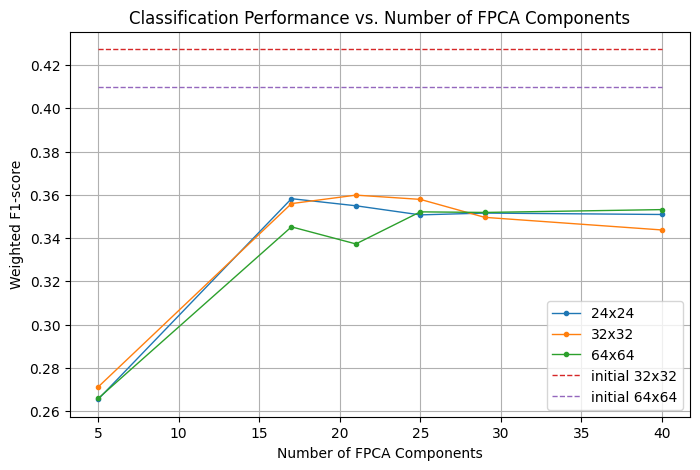

In [17]:
plt.figure(figsize=(8, 5))

plt.plot(acc_list_x_reduced, XGBf1_scores24, 'o-', linewidth=1, markersize=3, label='24x24')
plt.plot(acc_list_x_reduced, XGBf1_scores32, 'o-', linewidth=1, markersize=3, label='32x32')
plt.plot(acc_list_x_reduced, XGBf1_scores64, 'o-', linewidth=1, markersize=3, label='64x64')

plt.plot([5,40], [f1_xgb, f1_xgb], '--', linewidth=1, label='initial 32x32')
plt.plot([5,40], [f1_xgb_high, f1_xgb_high], '--', linewidth=1, label='initial 64x64')
#plt.plot(acc_list_x, psnr_list, 'o-', linewidth=2, markersize=8, label='PSNR')
plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('Weighted F1-score')
plt.legend()
plt.title('Classification Performance vs. Number of FPCA Components')
plt.show()

XGBoost performs better than MLP on original data without FPCA. Directly using raw image pixels (flattened) still achieves higher F1-scores. However, CatBoost on FPCA reaches higher score.


Other chart features like rapid increase and plateauing remain the same as for CatBoost or MLP. 


### CatBoost
1. CatBoost on raw CIFAR‐10 data performs better, than FPCA (0.45 vs 0.42), but the gap narrows once 15–20 components are included. This implies that a moderate number of PC can nearly match the performance of the classifier trained directly on the original pixels.

2. All three resolutions converge near 0.40–0.42 F1‐score, the 64×64 curve tends to reach higher values slightly earlier, reflecting that finer grids provide more discriminative features for FPCA to extract.

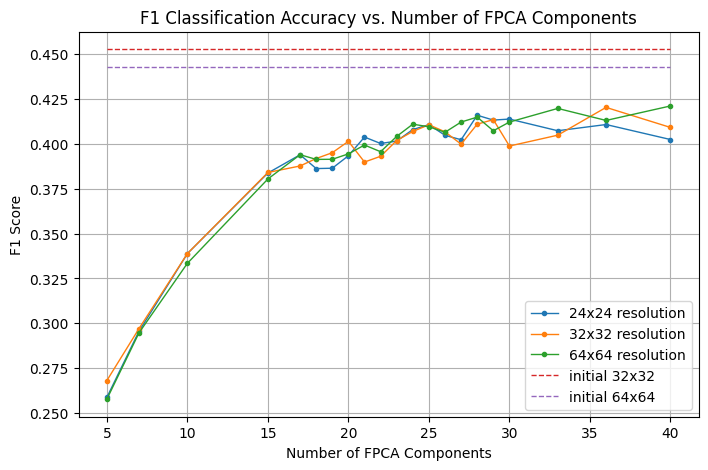

In [24]:
# Plot the average SSIM as a function of the number of FPCA components
plt.figure(figsize=(8, 5))

plt.plot(acc_list_x, acc_low_list1, 'o-', linewidth=1, markersize=3, label = '24x24 resolution')
plt.plot(acc_list_x, acc_low_list, 'o-', linewidth=1, markersize=3, label = '32x32 resolution')
plt.plot(acc_list_x, acc_list, 'o-', linewidth=1, markersize=3, label = '64x64 resolution')

plt.plot([5,40], [f1_cat, f1_cat], '--', linewidth=1, label='initial 32x32')
plt.plot([5,40], [f1_cat_high, f1_cat_high], '--', linewidth=1, label='initial 64x64')

plt.grid(True)
plt.xlabel('Number of FPCA Components')
plt.ylabel('F1 Score')
plt.title("F1 Classification Accuracy vs. Number of FPCA Components")
plt.legend()
plt.show()


## Conclusion

1. **Consistent Gains**: 10–15 components capture ~70–80% of meaningful variance.

2. **Diminishing Returns** Beyond ~20 Components: Adding more components beyond ~20 yields smaller gains, indicating that key modes of variation are typically contained in the lower‐order eigenfunctions.

3. **Multi‐Resolution Flexibility:** FPCA can handle data with different grid sizes, the quality of classification is similar on all datasets with different resolutions. Moreover, accuracy with FPCA components via CatBoost exceeds accuracy of classification of the initial data.

4. **Classification Performance** (Using F1 Score):
- For low-resolution images (e.g., 32×32), F1 scores improve from ~0.27 (with 5 components) to around 0.41 (with 30 components).
- For high-resolution images (64×64), the F1 scores similarly increase, reaching values near 0.42 with 40 components.

5. **Eigenfunction Consistency**: Despite sign inversions, the subspace spanned by the top components remains consistent across different resolutions.



## Save models for later

In [ ]:
import pickle
# Save the list of FPCA models to an external file using pickle
with open('fpca_models24.pkl', 'wb') as f:
    pickle.dump(fpca_low_list1, f)
with open('fpca_models32.pkl', 'wb') as f:
    pickle.dump(fpca_low_list, f)
with open('fpca_models64.pkl', 'wb') as f:
    pickle.dump(fpca_list, f)

Here is a code to extract trained models:

In [1]:
import pickle
    
with open('fpca_models24.pkl', 'rb') as f:
    fpca_low_list1 = pickle.load(f)
with open('fpca_models32.pkl', 'rb') as f:
    fpca_low_list = pickle.load(f)
with open('fpca_models64.pkl', 'rb') as f:
    fpca_list = pickle.load(f)